SIGNATURE VERIFICATION 

IMPORT THE LIBRARIES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from glob import glob



READING THE DATA PATH (SigComp Dataset)

In [3]:
IMAGE_SIZE = [224, 224]

train_path = "/content/drive/MyDrive/sign_data_mod_mod/train"
test_path  = "/content/drive/MyDrive/sign_data_mod_mod/test"

DATA AUGMENTATION

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

TRAINING DATASET

In [5]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,color_mode='rgb',
                                                 class_mode = 'categorical')

Found 1649 images belonging to 2 classes.


TESTING DATASET

In [6]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,color_mode='rgb',
                                            class_mode = 'categorical')

Found 500 images belonging to 2 classes.


In [7]:
training_set.class_indices

{'FORGED': 0, 'GENUINE': 1}

In [8]:
test_set.class_indices


{'FORGED': 0, 'GENUINE': 1}

DATA AUGMENTED IMAGES




In [9]:
def Show_Image(img_arr):
  fig,axes=plt.subplots(1,5,figsize=(20,20))
  axes=axes.flatten()

  for img,ax in zip(img_arr,axes):
    ax.imshow(img)
  
  plt.tight_layout()
  plt.show()

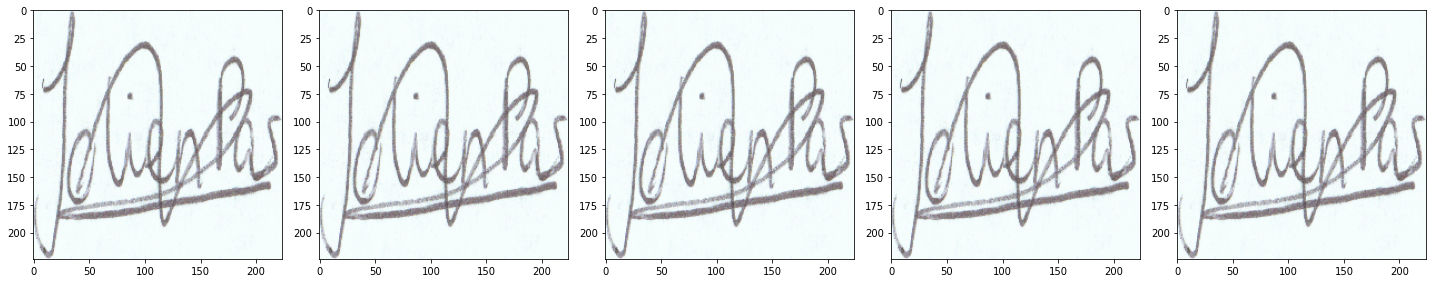

In [10]:
images=[training_set[0][0][0] for i in range(6)]
Show_Image(images)

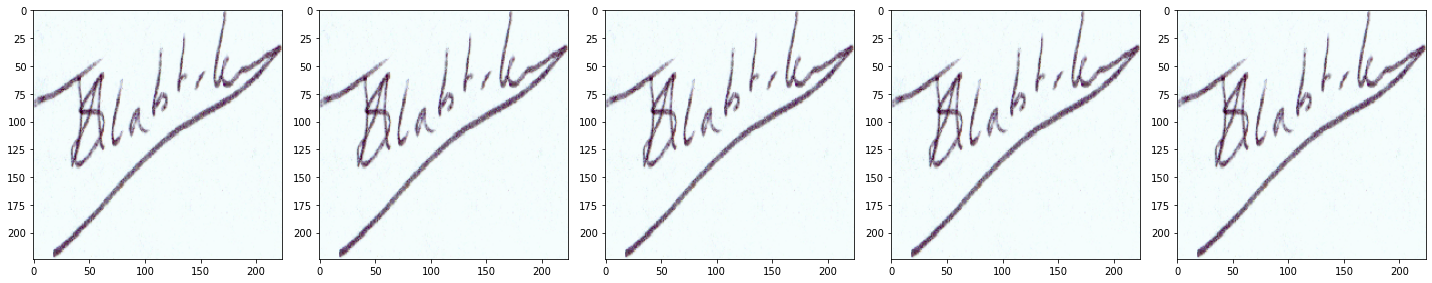

In [11]:
images=[test_set[0][0][0] for i in range(6)]
Show_Image(images)

INCEPTIONV3 MODEL FOR TRAINING

In [12]:
inception = InceptionV3(input_shape= IMAGE_SIZE + [3],weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [13]:
for layer in inception.layers:
    layer.trainable = False

In [14]:
folders = glob('/content/drive/MyDrive/sign_data_mod_mod/train/*')

In [15]:
folders

['/content/drive/MyDrive/sign_data_mod_mod/train/FORGED',
 '/content/drive/MyDrive/sign_data_mod_mod/train/GENUINE']

In [16]:
x = Flatten()(inception.output)

In [17]:
prediction = Dense(len(folders), activation='softmax')(x)


In [18]:
model = Model(inception.input, outputs=prediction)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=[tensorflow.keras.metrics.AUC(),"accuracy"])


MODEL TRAINING

In [21]:
result = model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/50
52/52 [==============================] - 1097s 21s/step - loss: 3.8040 - auc: 0.6609 - accuracy: 0.6315 - val_loss: 0.9766 - val_auc: 0.8724 - val_accuracy: 0.8060
Epoch 2/50
52/52 [==============================] - 14s 269ms/step - loss: 0.3837 - auc: 0.9489 - accuracy: 0.8909 - val_loss: 0.1217 - val_auc: 0.9910 - val_accuracy: 0.9540
Epoch 3/50
52/52 [==============================] - 14s 272ms/step - loss: 0.1135 - auc: 0.9921 - accuracy: 0.9518 - val_loss: 0.0717 - val_auc: 0.9970 - val_accuracy: 0.9720
Epoch 4/50
52/52 [==============================] - 14s 272ms/step - loss: 0.1760 - auc: 0.9853 - accuracy: 0.9341 - val_loss: 0.0617 - val_auc: 0.9962 - val_accuracy: 0.9760
Epoch 5/50
52/52 [==============================] - 14s 273ms/step - loss: 0.0576 - auc: 0.9981 - accuracy: 0.9799 - val_loss: 0.0237 - val_auc: 0.9995 - val_accuracy: 0.9940
Epoch 6/50
52/52 [==============================] - 14s 270ms/step - loss: 0.0092 - auc: 1.0000 - accuracy: 0.9989 - val_loss

LOSS AND ACCURACY

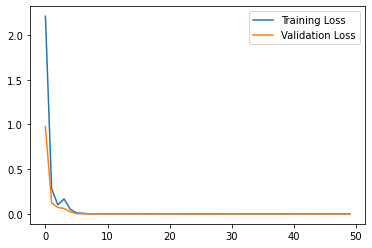

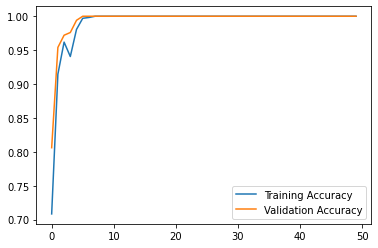

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(result.history['loss'], label='Training Loss')
plt.plot(result.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('Loss_Value')


plt.plot(result.history['accuracy'], label='Training Accuracy')
plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig('Accuracy_Value')

THE FINAL MODEL

In [24]:
model.save('/content/drive/MyDrive/sign_data_mod_mod/Model_InceptionV3_SigComp.h5')